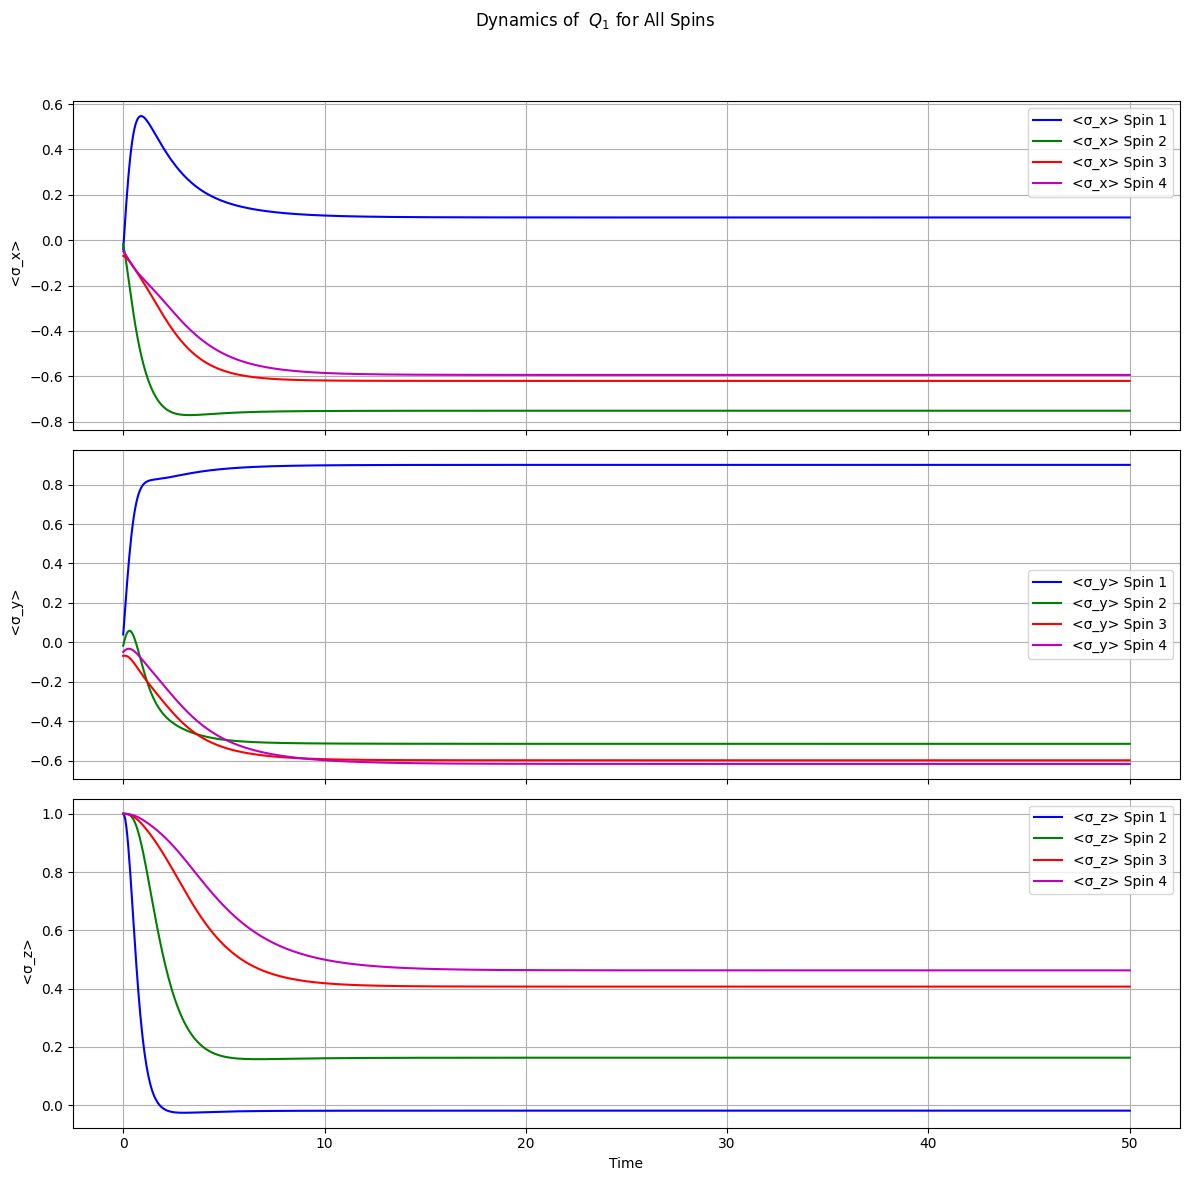

Parameters for Q_1:
B_1 = [0.0000+0.6455j, 0.0000+0.6455j, 1.0000+0.0000j]
Initial state: |0000>
Sample dynamics (t, <σ_x>, <σ_y>, <σ_z> for spins 1-4):
t = 0.00
 Spin 1: <σ_x> = -0.0398, <σ_y> = 0.0398, <σ_z> = 1.0000
 Spin 2: <σ_x> = -0.0171, <σ_y> = -0.0171, <σ_z> = 1.0000
 Spin 3: <σ_x> = -0.0691, <σ_y> = -0.0691, <σ_z> = 1.0000
 Spin 4: <σ_x> = -0.0489, <σ_y> = -0.0489, <σ_z> = 1.0000
t = 5.01
 Spin 1: <σ_x> = 0.1700, <σ_y> = 0.8801, <σ_z> = -0.0219
 Spin 2: <σ_x> = -0.7626, <σ_y> = -0.4945, <σ_z> = 0.1669
 Spin 3: <σ_x> = -0.5757, <σ_y> = -0.5336, <σ_z> = 0.5492
 Spin 4: <σ_x> = -0.5013, <σ_y> = -0.4905, <σ_z> = 0.6833
t = 10.01
 Spin 1: <σ_x> = 0.1084, <σ_y> = 0.8982, <σ_z> = -0.0189
 Spin 2: <σ_x> = -0.7529, <σ_y> = -0.5135, <σ_z> = 0.1611
 Spin 3: <σ_x> = -0.6185, <σ_y> = -0.5932, <σ_z> = 0.4184
 Spin 4: <σ_x> = -0.5853, <σ_y> = -0.5985, <σ_z> = 0.4993
t = 15.02
 Spin 1: <σ_x> = 0.1012, <σ_y> = 0.9002, <σ_z> = -0.0186
 Spin 2: <σ_x> = -0.7518, <σ_y> = -0.5150, <σ_z> = 0.1628
 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
sigma = [sigma_x, sigma_y, sigma_z]

def define_parameters(N=4):
    """Define PT-symmetric parameters"""
    gamma = 1j*0.5
    lambda_ =1j* 0.5
    bz = 1
    g = 0.1

    alpha_x = 1.0
    alpha_y = 1.0
    beta_x = 0.5
    beta_y = 0.5

    epsilon = np.array([0.1, 0.3, 0.5, 0.7], dtype=complex)

    B_vectors = np.zeros((N, 3), dtype=complex)
    for i in range(1, N+1):  # Spin indices now run from 1 to N
        B_vectors[i-1, 0] = gamma / np.sqrt(alpha_x * epsilon[i-1] + beta_x)
        B_vectors[i-1, 1] = lambda_ / np.sqrt(alpha_y * epsilon[i-1] + beta_y)
        B_vectors[i-1, 2] = bz

    Gamma = np.zeros((N, N, 3), dtype=complex)
    for i in range(1, N+1):  # Spin indices now run from 1 to N
        for j in range(1, N+1):
            if i != j:
                denom = epsilon[i-1] - epsilon[j-1]
                Gamma[i-1, j-1, 0] = 1j*g * np.sqrt((alpha_x * epsilon[i-1] + beta_x) *
                                                 (alpha_y * epsilon[j-1] + beta_y)) / denom
                Gamma[i-1, j-1, 1] = 1j*g * np.sqrt((alpha_y * epsilon[i-1] + beta_y) *
                                                 (alpha_x * epsilon[j-1] + beta_x)) / denom
                Gamma[i-1, j-1, 2] = g * np.sqrt((alpha_x * epsilon[j-1] + beta_x) *
                                                 (alpha_y * epsilon[j-1] + beta_y)) / denom

    return B_vectors, Gamma, epsilon

def construct_Qi(i, B_vectors, Gamma, N=4):
    """Construct PT-symmetric Q_i (spin index runs from 1 to N)"""
    dim = 2**N
    Qi = np.zeros((dim, dim), dtype=complex)

    Bi_sigma = (B_vectors[i-1, 0] * sigma_x +
                B_vectors[i-1, 1] * sigma_y +
                B_vectors[i-1, 2] * sigma_z)
    operators = [np.eye(2, dtype=complex)] * N
    operators[i-1] = Bi_sigma
    Qi_term = operators[0]
    for k in range(1, N):
        Qi_term = np.kron(Qi_term, operators[k])
    Qi += Qi_term

    for k in range(1, N+1):  # Spin indices now run from 1 to N
        if k != i:
            for alpha in range(3):
                if Gamma[i-1, k-1, alpha] != 0:
                    operators = [np.eye(2, dtype=complex)] * N
                    operators[i-1] = sigma[alpha]
                    operators[k-1] = sigma[alpha]
                    Qi_term = operators[0]
                    for j in range(1, N):
                        Qi_term = np.kron(Qi_term, operators[j])
                    Qi += Gamma[i-1, k-1, alpha] * Qi_term

    return Qi

def parity_operator(N=4):
    """Parity operator P (swaps spins: 1↔4, 2↔3)"""
    dim = 2**N
    P = np.zeros((dim, dim), dtype=complex)
    basis = [format(x, f'0{N}b') for x in range(dim)]
    for i, state in enumerate(basis):
        reversed_state = state[::-1]
        j = int(reversed_state, 2)
        P[i, j] = 1.0
    return P

def construct_C_operator(Qi, eigenvectors):
    """Approximate C operator"""
    dim = Qi.shape[0]
    C = np.zeros((dim, dim), dtype=complex)
    P = parity_operator()

    for n in range(dim):
        psi = eigenvectors[:, n]
        psi_pt = P @ np.conjugate(psi)
        C += np.outer(psi, psi_pt)

    C /= np.trace(C).real
    return C

def sigma_operator(spin_idx, pauli_idx, N=4):
    """Construct σ_x, σ_y, or σ_z operator for a specific spin (spin index runs from 1 to N)"""
    dim = 2**N
    operators = [np.eye(2, dtype=complex)] * N
    operators[spin_idx-1] = sigma[pauli_idx]  # Adjusted for spin index 1 to N
    op = operators[0]
    for k in range(1, N):
        op = np.kron(op, operators[k])
    return op

def simulate_dynamics_all_spins(i=1, t_max=10.0, steps=100):
    """Simulate and plot dynamics of <σ_x>, <σ_y>, <σ_z> for all 4 spins (spin index runs from 1 to N)"""
    B_vectors, Gamma, epsilon = define_parameters()
    Qi = construct_Qi(i, B_vectors, Gamma)

    # Initial state: |0000>
    dim = 2**4
    psi0 = np.zeros(dim, dtype=complex)
    psi0[0] = 1.0  # |0000>

    # Get eigenvectors for C operator
    _, eigenvectors = np.linalg.eig(Qi)
    P = parity_operator()
    C = construct_C_operator(Qi, eigenvectors)

    # Time points
    t_values = np.linspace(0, t_max, steps)

    # Sigma operators for all spins (x, y, z)
    sigma_ops = [[sigma_operator(k, pauli_idx) for k in range(1, 5)] for pauli_idx in range(3)]

    # Store dynamics: [pauli_idx][spin_idx][time]
    sigma_exp_all = [[[] for _ in range(4)] for _ in range(3)]  # Corrected initialization

    for t in t_values:
        # Time evolution
        U = expm(-1j * Qi * t)
        psi_t = U @ psi0

        # CPT inner product components
        cp_psi_t = C @ (P @ psi_t)

        # CPT norm
        norm_cpt = np.vdot(psi_t, cp_psi_t).real

        # Expectation values for σ_x, σ_y, σ_z for each spin
        for pauli_idx in range(3):  # 0: x, 1: y, 2: z
            for k in range(1, 5):  # Spin indices now run from 1 to N
                sigma_num = np.vdot(psi_t, sigma_ops[pauli_idx][k-1] @ cp_psi_t).real
                sigma_exp = sigma_num / norm_cpt if norm_cpt != 0 else 0
                sigma_exp_all[pauli_idx][k-1].append(sigma_exp)

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    colors = ['b', 'g', 'r', 'm']
    labels = ['σ_x', 'σ_y', 'σ_z']
    axes = [ax1, ax2, ax3]

    for pauli_idx in range(3):
        for k in range(1, 5):  # Spin indices now run from 1 to N
            axes[pauli_idx].plot(t_values, sigma_exp_all[pauli_idx][k-1],
                                 f'{colors[k-1]}-', label=f'<{labels[pauli_idx]}> Spin {k}')
        axes[pauli_idx].set_ylabel(f' <{labels[pauli_idx]}>')
        axes[pauli_idx].grid(True)
        axes[pauli_idx].legend()

    ax3.set_xlabel('Time')
    fig.suptitle(f'Dynamics of  $Q_{i}$ for All Spins')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print initial info
    print(f"Parameters for Q_{i}:")
    print(f"B_{i} = [{B_vectors[i-1,0]:.4f}, {B_vectors[i-1,1]:.4f}, {B_vectors[i-1,2]:.4f}]")
    print(f"Initial state: |0000>")
    print("Sample dynamics (t, <σ_x>, <σ_y>, <σ_z> for spins 1-4):")
    sample_indices = range(0, steps, steps // 10)  # 10 evenly spaced points
    for idx in sample_indices:
        t = t_values[idx]
        print(f"t = {t:.2f}")
        for k in range(1, 5):  # Spin indices now run from 1 to N
            sx = sigma_exp_all[0][k-1][idx]
            sy = sigma_exp_all[1][k-1][idx]
            sz = sigma_exp_all[2][k-1][idx]
            print(f" Spin {k}: <σ_x> = {sx:.4f}, <σ_y> = {sy:.4f}, <σ_z> = {sz:.4f}")

if __name__ == "__main__":
    simulate_dynamics_all_spins(i=1, t_max=50.0, steps=1000)